In [ ]:
import os
import shutil
from datetime import datetime, timedelta
import urllib
import zipfile
import matplotlib.pyplot as plt
import requests
import pandas as pd
import requests
import zipfile
from io import BytesIO
from tqdm.notebook import tqdm

# Environment Variables

In [ ]:
COMPUTING_ENV = 'aws' # must set to "local" or "remote" before running

In [ ]:
if COMPUTING_ENV == 'windows':
    WORKING_DIR = "C:\\Users\\regin\\Dropbox\\ibis"
    API_KEYS_DIR = "C:\\Users\\regin\\Dropbox\\API_KEYS"
elif COMPUTING_ENV == 'ubuntu':
    WORKING_DIR = "/home/reggie//Dropbox/ibis"
    API_KEYS_DIR = "/home/reggie/Dropbox/API_KEYS"
elif COMPUTING_ENV == 'aws':
    WORKING_DIR = "/home/ubuntu/ibis"
    API_KEYS_DIR = "/home/ubuntu/API_KEYS"

DATA_DIR = os.path.join(WORKING_DIR, "data")
FRD_DATA_DIR = os.path.join(DATA_DIR, 'frd-historical')

stock_download_directories = pd.read_csv(os.path.join(FRD_DATA_DIR, 'stock-download-directories.csv'))
stock_download_directories

In [ ]:
timeframes = ["1min", "5min", "daily", "weekly", "monthly"]
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

print(f"Working directory:\n\t{WORKING_DIR}")
print(f"Data directory:\n\t{DATA_DIR}")
print(f"FRD data directory:\n\t{FRD_DATA_DIR}")

# make dirs
for d in [DATA_DIR, FRD_DATA_DIR,]:
    if not os.path.exists(d):
        print(f"Creating {d}")
        os.makedirs(d)



FRD_USER_ID = open(os.path.join(API_KEYS_DIR, 'FRD-USER-ID')).read().strip()
print(f"FRD User ID: {FRD_USER_ID}")

# Utilities

In [123]:
def download_frd_data(params, zips_dir, overwrite=False):
    period = params['period']
    adjustment = params['adjustment']
    timeframe = params['timeframe']

    if period == 'full':
        ticker_range = params['ticker_range']
        zip_fp = os.path.join(zips_dir, f"{ticker_range}_{period}_{adjustment}_{timeframe}.zip")
    else:
        zip_fp = os.path.join(zips_dir, f"{period}_{adjustment}_{timeframe}.zip")

    if os.path.exists(zip_fp) and not overwrite:
        print(f"File already exists: {zip_fp}")
        return
    
    base_url = "https://firstratedata.com/api/data_file"
    
    response = requests.get(base_url, params=params)
    print(response.url)
    if response.status_code == 200:      
        with open(zip_fp, 'wb') as file:
            file.write(response.content)
        print(f"ZIP file saved: {zip_fp}")
    else:
        print(f"Failed to download data: {response.status_code}")

def extract_frd_zip(
        src_zips_dir, 
        dest_csv_dir, 
        ticker_first_letter='', 
        period='full', 
        adjustment='adj_splitdiv', 
        timeframe='1min', 
        overwrite=False):
    if period == 'full':
        src_zip_fp = os.path.join(src_zips_dir, f"{ticker_first_letter}_{period}_{adjustment}_{timeframe}.zip")
        dest_csv_fp = os.path.join(dest_csv_dir, ticker_first_letter)
    else:
        src_zip_fp = os.path.join(src_zips_dir, f"{period}_{adjustment}_{timeframe}.zip")
        dest_csv_fp = dest_csv_dir
    dest_dir_size = len(os.listdir(dest_csv_fp))

    # extract if overwrite == True or directory is empty
    if (dest_dir_size == 0) or overwrite:
        if os.path.isfile(src_zip_fp):
            print(f"Extracting {src_zip_fp} to {dest_csv_fp}")
        else:
            print(f"File not found: {src_zip_fp}")
            return
        with zipfile.ZipFile(src_zip_fp, 'r') as zip_ref:
            zip_ref.extractall(dest_csv_fp)
    else:
        print(f"{dest_csv_fp} not empty with {dest_dir_size} files")
        return
    
def make_zips_and_csv_dirs(params):
    data_date = datetime.now().strftime('%Y%m%d')
    adjustment = params['adjustment']
    timeframe = params['timeframe']
    period = params['period']
    
    _dir = stock_download_directories.query(f"type == 'stock' & timeframe == '{timeframe}' & adjustment == '{adjustment}'")['directory'].values[0]
    
    if period == 'day':
        _dir = _dir.replace('stock', f'stock_day_{data_date}')
    elif period == 'week':
        _dir = _dir.replace('stock', f'stock_week_{data_date}')
    elif period == 'month':
        _dir = _dir.replace('stock', f'stock_month_{data_date}')
    _dir = os.path.join(FRD_DATA_DIR, _dir)
    zips_dir = os.path.join(_dir, 'zips')
    csv_dir = os.path.join(_dir, 'csv')


    return zips_dir, csv_dir

# Download Full History

## 1 Minute Stock Bars Adjusted for Splits and Dividends

In [ ]:
params = {
    "type": "stock",
    "ticker_range": "",
    "timeframe": "1min",
    "adjustment": "adj_splitdiv",
    "period": "full",
    'userid': FRD_USER_ID
}

In [ ]:
ZIPS_DIR, CSV_DIR = make_zips_and_csv_dirs(params)
print(f"ZIPS_DIR: {ZIPS_DIR}")
print(f"CSV_DIR: {CSV_DIR}")

if not os.path.exists(CSV_DIR):
    print(f"Creating {CSV_DIR}")
    os.makedirs(CSV_DIR)
else:
    print(f"{CSV_DIR} exists with {len(os.listdir(CSV_DIR))} files")
if not os.path.exists(ZIPS_DIR):
    print(f"Creating {ZIPS_DIR}")
    os.makedirs(ZIPS_DIR)
else:
    print(f"{ZIPS_DIR} exists with {len(os.listdir(ZIPS_DIR))} files")

for ticker_first_letter in letters:
    ticker_csv_dir = os.path.join(CSV_DIR, ticker_first_letter)
    print(ticker_csv_dir)
    
    if not os.path.exists(ticker_csv_dir):
        os.makedirs(ticker_csv_dir)
        print(f"Creating {ticker_csv_dir}")
    else:
        print(f"{ticker_csv_dir} exists with {len(os.listdir(ticker_csv_dir))} files")

In [ ]:
for ticker_first_letter in tqdm(letters):
    params['ticker_range'] = ticker_first_letter
    print(f"Downloading data for {ticker_first_letter}...")
    download_frd_data(params=params, zips_dir=ZIPS_DIR, overwrite=False)

In [ ]:
for letter in tqdm(letters):
    extract_frd_zip(
        src_zips_dir=ZIPS_DIR, 
        dest_csv_dir=CSV_DIR,
        ticker_first_letter=letter,
        period=params['period'],
        adjustment=params['adjustment'],
        timeframe=params['timeframe'],
        overwrite=True
    )

## 5 Minute Stock Bars Adjusted for Splits and Dividends

In [ ]:
params ={
    "type": "stock",
    "ticker_range": "",
    "timeframe": "5min",
    "adjustment": "adj_splitdiv",
    "period": "full",
    'userid': FRD_USER_ID
}

In [ ]:
ZIPS_DIR, CSV_DIR = make_zips_and_csv_dirs(params)
print(f"ZIPS_DIR: {ZIPS_DIR}")
print(f"CSV_DIR: {CSV_DIR}")

if not os.path.exists(CSV_DIR):
    print(f"Creating {CSV_DIR}")
    os.makedirs(CSV_DIR)
else:
    print(f"{CSV_DIR} exists with {len(os.listdir(CSV_DIR))} files")
if not os.path.exists(ZIPS_DIR):
    print(f"Creating {ZIPS_DIR}")
    os.makedirs(ZIPS_DIR)
else:
    print(f"{ZIPS_DIR} exists with {len(os.listdir(ZIPS_DIR))} files")

for ticker_first_letter in letters:
    ticker_csv_dir = os.path.join(CSV_DIR, ticker_first_letter)
    print(ticker_csv_dir)
    
    if not os.path.exists(ticker_csv_dir):
        os.makedirs(ticker_csv_dir)
        print(f"Creating {ticker_csv_dir}")
    else:
        print(f"{ticker_csv_dir} exists with {len(os.listdir(ticker_csv_dir))} files")

In [ ]:
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#letters = ['X', 'Y']
for ticker_first_letter in tqdm(letters):
    params['ticker_range'] = ticker_first_letter
    print(f"Downloading data for {ticker_first_letter}...")
    download_frd_data(params=params, zips_dir=ZIPS_DIR, overwrite=False)

In [ ]:
for letter in tqdm(letters):
    extract_frd_zip(
        src_zips_dir=ZIPS_DIR, 
        dest_csv_dir=CSV_DIR,
        ticker_first_letter=letter,
        period=params['period'],
        adjustment=params['adjustment'],
        timeframe=params['timeframe'],
        overwrite=False
    )

# Download Weekly Updates

## 1 min

In [115]:
params ={
    "type": "stock",
    "timeframe": "1min",
    "adjustment": "adj_splitdiv",
    "period": "week",
    'userid': FRD_USER_ID
}

ZIPS_DIR, CSV_DIR = make_zips_and_csv_dirs(params)
print(f"ZIPS_DIR: {ZIPS_DIR}")
print(f"CSV_DIR: {CSV_DIR}")

if not os.path.exists(CSV_DIR):
    print(f"Creating {CSV_DIR}")
    os.makedirs(CSV_DIR)
else:
    print(f"{CSV_DIR} exists with {len(os.listdir(CSV_DIR))} files")
if not os.path.exists(ZIPS_DIR):
    print(f"Creating {ZIPS_DIR}")
    os.makedirs(ZIPS_DIR)
else:
    print(f"{ZIPS_DIR} exists with {len(os.listdir(ZIPS_DIR))} files")

ZIPS_DIR: /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/zips
CSV_DIR: /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv
/home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv exists with 0 files
/home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/zips exists with 0 files


In [120]:
download_frd_data(params=params, zips_dir=ZIPS_DIR, overwrite=False)

https://f004.backblazeb2.com/file/frd-apix03/stock_update_week_1min_adjsplitdiv_jabm3fa.zip
ZIP file saved: /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/zips/week_adj_splitdiv_1min.zip


In [124]:
extract_frd_zip(
    src_zips_dir=ZIPS_DIR, 
    dest_csv_dir=CSV_DIR,
    
    period=params['period'],
    adjustment=params['adjustment'],
    timeframe=params['timeframe'],
    overwrite=True
)

  0%|          | 0/2 [00:00<?, ?it/s]

Extracting /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/zips/week_adj_splitdiv_1min.zip to /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv
Extracting /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/zips/week_adj_splitdiv_1min.zip to /home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv


In [127]:
CSV_DIR

'/home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv'

In [155]:
ticker = 'RDFN'
fp = f"{ticker}_{period}_{timeframe}_{adjustment.replace('_','')}.txt"
fp = os.path.join(CSV_DIR, fp)
print(fp)
rdfn_df = pd.read_csv(fp, names=['date', 'open', 'high', 'low', 'close', 'volume'])
rdfn_df['ret'] = rdfn_df['close'].pct_change()
rdfn_df['date'] = pd.to_datetime(rdfn_df['date'])
rdfn_df.set_index('date', inplace=True)
rdfn_df

/home/ubuntu/ibis/data/frd-historical/stock_week_20240915/adj_splitdiv/1min/csv/RDFN_week_1min_adjsplitdiv.txt


,open,high,low,close,volume,ret
date,,,,,,
2024-09-09 07:11:00,9.4200,9.4200,9.4200,9.4200,500,NaN
2024-09-09 07:46:00,9.4000,9.4000,9.3500,9.3500,402,-0.007431
2024-09-09 08:00:00,9.6164,9.6164,9.6164,9.6164,500,0.028492
2024-09-09 08:06:00,9.4400,9.4400,9.4400,9.4400,10000,-0.018344
2024-09-09 08:07:00,9.4500,9.4500,9.4500,9.4500,3100,0.001059
...,...,...,...,...,...,...
2024-09-13 19:54:00,14.5000,14.5000,14.5000,14.5000,1760,0.000000
2024-09-13 19:56:00,14.5200,14.5200,14.5200,14.5200,150,0.001379
2024-09-13 19:57:00,14.5390,14.5390,14.5200,14.5200,530,0.000000


In [146]:
import matplotlib.pyplot as plt

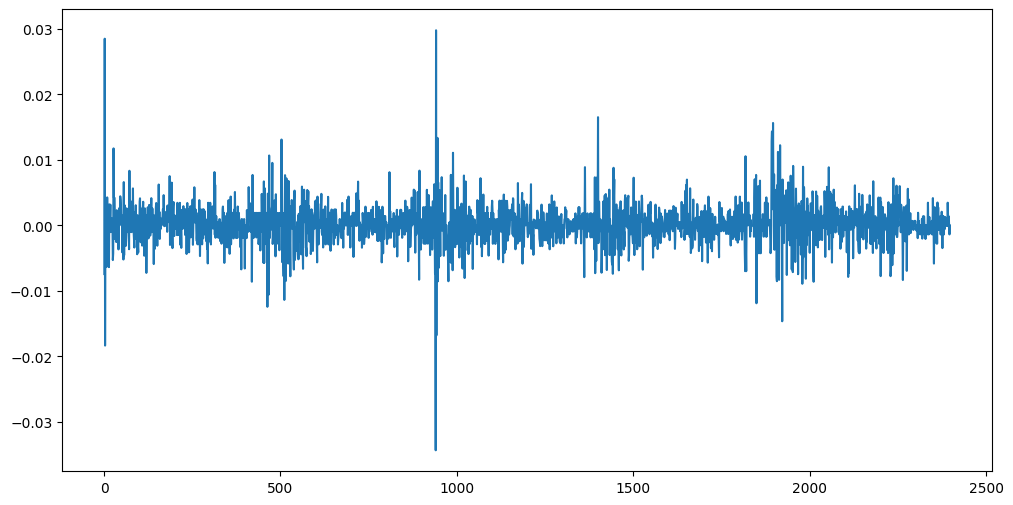

In [153]:
# add returns

plt.figure(figsize=(12, 6))
plt.plot(rdfn_df['ret'].values)
plt.show()

In [161]:
# resample to daily values
rdfn_daily_df = rdfn_df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
})
print(rdfn_daily_df.info())
rdfn_daily_df['close_to_close_ret'] = rdfn_daily_df['close'].pct_change()
rdfn_daily_df['intraday_ret'] = rdfn_daily_df['close']/rdfn_daily_df['open'] - 1
rdfn_daily_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2024-09-09 to 2024-09-13
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5 non-null      float64
 1   high    5 non-null      float64
 2   low     5 non-null      float64
 3   close   5 non-null      float64
 4   volume  5 non-null      int64  
dtypes: float64(4), int64(1)
memory usage: 240.0 bytes
None


,open,high,low,close,volume,ret,intraday_ret
date,,,,,,,
2024-09-09,9.42,10.590,9.30,10.4600,6998002,NaN,0.110403
2024-09-10,10.33,10.850,10.04,10.8000,4853960,0.032505,0.045499
2024-09-11,10.83,11.210,10.31,10.9000,5229246,0.009259,0.006464
2024-09-12,11.08,11.575,10.74,11.5487,5845292,0.059514,0.042301
2024-09-13,11.63,14.540,11.63,14.5000,16434551,0.255553,0.246776


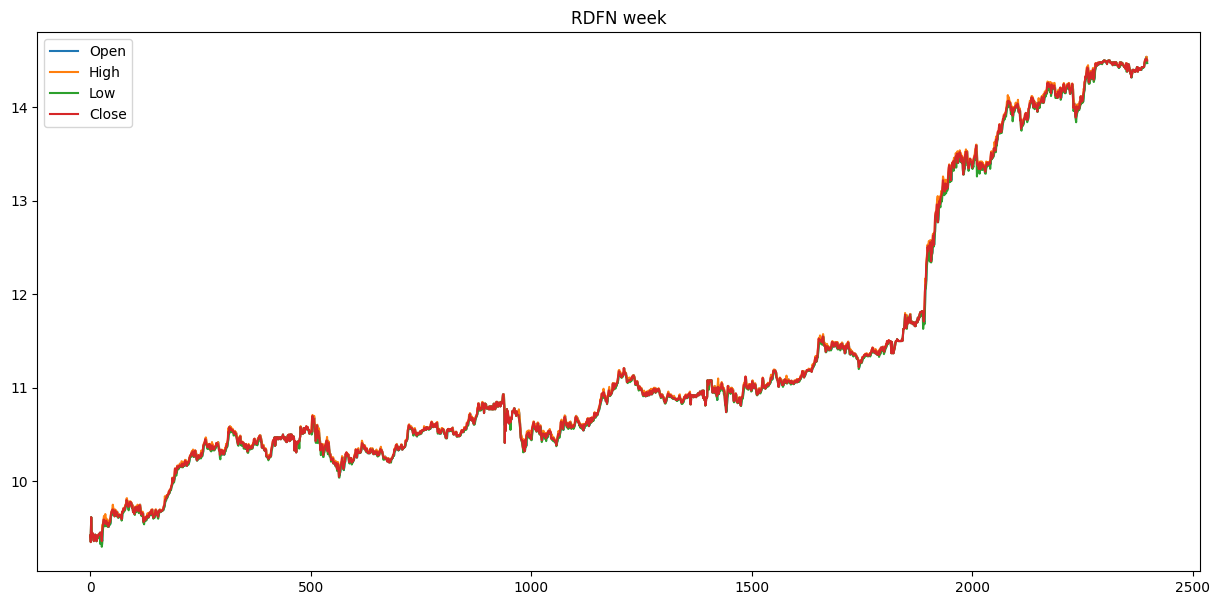

In [149]:
plt.figure(figsize=(15, 7))
plt.plot(rdfn_df['open'].values, label='Open')
plt.plot(rdfn_df['high'].values, label='High')
plt.plot(rdfn_df['low'].values, label='Low')
plt.plot(rdfn_df['close'].values, label='Close')
plt.legend()
plt.title(f"{ticker} {period}")
plt.show()